In [1]:
from dataclasses import dataclass
import typing as t
from enum import Enum
import os
from dotenv import load_dotenv

import torch
from torch import nn
from torchvision.utils import make_grid
import neptune.new as neptune
from neptune.new.types import File
from tqdm import tqdm
from scipy.signal import savgol_filter

from model import VQVAE, VQVAETrainer, QuantizationLoss
from data import CIFAR10DataLoader, ImageDatasetTransforms
from utils import plot_images_in_grid

load_dotenv()

/Users/danielvaroli/opt/anaconda3/envs/vq-vae-pt/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
@dataclass
class TrainingParameters:
    dataset_name: str
    n_epochs: int
    batch_size: int
    device_id: str
    hidden_dim: int = 128
    n_residual_layers: int = 2
    residual_layer_hidden_dim: int = 32
    n_embeddings: int = 512
    embedding_dim: int = 64
    hidden_activation_fn: nn.Module = nn.ReLU()
    ema_decay: float = 0.0
    commitment_term: float = 0.25
    seed: t.Optional[int] = None
    save_weights: bool = False
    optimizer: t.Optional[torch.optim.Optimizer] = None

    def get_config(self) -> t.Dict:
        d = self.__dict__
        activation_fn: nn.Module = d.pop('hidden_activation_fn')
        d["hidden_activation_fn_config"] = {
            "name": activation_fn.__class__.__name__,
            **activation_fn.__dict__
        }
        optimzer = d.pop("optimizer")
        d["optimizer_config"] = {
            "name": optimzer.__class__.__name__,
            **optimzer.__dict__["defaults"]
        }
        return d


In [3]:
device_id = "mps:0"
device = torch.device(device_id)

# hyperparameters
batch_size = 256
seed = None
n_epochs = 50

NEPTUNE_PROJECT_NAME = os.environ['NEPTUNE_PROJECT_NAME']
NEPTUNE_API_TOKEN = os.environ['NEPTUNE_API_TOKEN']

In [4]:
parameters = TrainingParameters(
    dataset_name="CIFAR10",
    n_epochs=n_epochs,
    device_id=device_id,
    batch_size=batch_size,
    seed=seed,
    save_weights=True,
    n_embeddings=10
)

In [5]:
train_loader = CIFAR10DataLoader(
    train=True, 
    shuffle=True, 
    batch_size=parameters.batch_size,
    transforms=ImageDatasetTransforms.HALF_RGB.value
)

Files already downloaded and verified


In [6]:
model = VQVAE(
    img_channels=3,
    hidden_dim=parameters.hidden_dim,
    n_residual_layers=parameters.n_residual_layers,
    residual_layer_hidden_dim=parameters.residual_layer_hidden_dim,
    n_embeddings=parameters.n_embeddings,
    embedding_dim=parameters.embedding_dim,
    hidden_activation_fn=parameters.hidden_activation_fn,
    ema_decay=parameters.ema_decay
)
model = model.to(device)

In [7]:
optimizer = torch.optim.Adam(model.parameters())
parameters.optimizer = optimizer

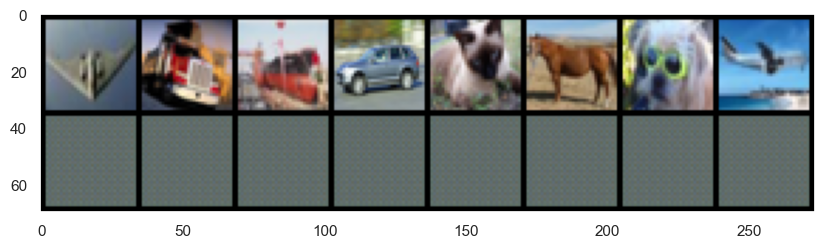

In [8]:
test_samples = train_loader.get_sample_images(8, seed=None).to(device)
with torch.no_grad():
    reconstructions = model(test_samples).cpu()
plot_images_in_grid(torch.concat((test_samples.cpu(), reconstructions), dim=0))

In [9]:
trainer = VQVAETrainer(
    model, 
    optimizer, 
    quantization_loss_fn=QuantizationLoss(parameters.commitment_term),
    device=device
)
print(f"Trainer device: {trainer.device}") 
print(f"Model parameters device: {list(model.parameters())[0].device}")

Trainer device: mps:0
Model parameters device: mps:0


In [10]:
run = neptune.init(
    project=NEPTUNE_PROJECT_NAME,
    api_token=NEPTUNE_API_TOKEN
)
run["parameters"] = parameters

https://app.neptune.ai/djvaroli/VQ-VAE/e/VQVAE-30


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [11]:
trainer.train(
    train_loader, 
    n_epochs=parameters.n_epochs, 
    neptune_run=run,
    test_samples=test_samples
)

Epoch 50 / 50: 100%|██████████| 196/196 [00:19<00:00, 10.22it/s, ReconstructionLoss=0.129, QuantizationLoss=0.169, Perplexity=9.42]


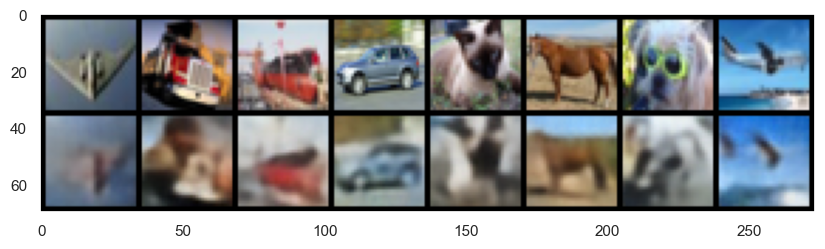

In [12]:
with torch.no_grad():
    reconstructions = model(test_samples).cpu()
plot_images_in_grid(torch.concat((test_samples.cpu(), reconstructions), dim=0))

In [13]:
if parameters.save_weights:
    torch.save(model.state_dict(), f"vqvae-weights_{run._id}.pt")

run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.
All 3 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/djvaroli/VQ-VAE/e/VQVAE-30
